# Module 3: Deep Learning with Keras
David John Gagne,
National Center for Atmospheric Research

## Goals of this Module
* Learn the definition of deep learning and how it differs from traditional machine learning approaches
* Understand what Keras is, how it works, and how it interfaces with other deep learning libraries
* Build a densely-connected neural network in Keras
* Discover how the choice of activation function affects performance
* Build a convolutional neural network in Keras and see how it performs compared with the dense neural network
* See how data are transformed by passing through convolutional layers

## Software Requirements
This module requires the following software libraries:
* Python 3.6 or higher
* Numpy
* Pandas
* Matplotlib
* IPython
* Jupyter
* Xarray
* netCDF4
* Tensorflow (GPU version recommended for training convolutional neural networks)
* Keras
* CUDA 9.2 or higher and cuDNN (for interfacing with NVIDIA GPU)

## What is Deep Learning?
![ai_ml_dl](ai_ml_dl_diagram.png)
Deep learning should be defined in the context of Artificial Intelligence and Machine Learning. 
* **Artificial Intelligence (AI)**: the many ways for computers to perform cognitive tasks traditionally accomplished by humans without direct control from humans.  
* Historically, there have been two schools of thought for developing AI systems.
    * **Expert Systems**: an expert at a task creates algorithms and rules that describe how a task is done, and then the AI program accomplishes the task based on the rules.
        * Often implemented as Fuzzy Logic
        * Operational Examples: NEXRAD Hydrometeor Classification Algorithm, Method for Object-based Diagnostic Evaluation
        * Pros: Requires no data, interpretable, manipulatable
        * Cons: Brittle algorithms, complexity hard to manage, not adaptive
    * **Machine Learning (ML)**: mathematical models with a specified structure that learn to perform tasks from data
        * Common algorithms: Neural networks, decision trees, support vector machines
        * Pros: Potentially high predictive skill, can learn complex patterns and relationships, quantify uncertainty, interpretable
        * Cons: Requires large amounts of data, extensive pre-processing of features, extrapolation issues
* **Deep Learning**: A subset of machine learning consisting of neural networks with many specialized hidden layers for encoding structural patterns in input data to produce better predictions
    * Common algorithms: convolutional neural networks, recurrent neural networks
    * Pros: Increased predictive skill over traditional ML on image and time-series problems, less pre-processing and feature engineering required
    * Cons: Requires more data and computational resources than traditional machine learning, harder to train well, greater sensitivity to adversarial data

## What is Keras?
![power_rankings](https://cdn-images-1.medium.com/max/1600/1*s_BwkYxpGv34vjOHi8tDzg.png)
Keras is a human-centered high-level API for deep learning. Keras provides an object-oriented interface for creating neural networks of arbitrary complexity by connecting layers together in different ways. Keras serves as the official high-level API for Tensorflow and can also interface with Theano and Microsoft's CNTK. By many measures it is the second most popular deep learning library after Tensorflow. 

## Data Processing

In [186]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, expanduser
from sklearn.preprocessing import StandardScaler

In [9]:
csv_path = "data/track_data_ncar_ams_3km_csv_small/"
csv_files = sorted(glob(join(csv_path, "*.csv")))
csv_data_list = []
for csv_file in csv_files:
    print(csv_file)
    csv_data_list.append(pd.read_csv(csv_file))
csv_data = pd.concat(csv_data_list, ignore_index=True)
del csv_data_list

data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110509-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110522-0000.csv
data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110527-0000.csv
data/track_data_

In [11]:
csv_data.columns

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

In [17]:
input_columns = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean"]
output_column = "RVORT1_MAX-future_max"
out_threshold = 0.006
train_test_date = pd.Timestamp("2015-01-01")
valid_dates = pd.DatetimeIndex(csv_data["Valid_Date"])
train_data = csv_data.loc[valid_dates < train_test_date, input_columns]
train_out = np.where(csv_data.loc[valid_dates < train_test_date, output_column] > out_threshold, 1, 0)
test_data = csv_data.loc[valid_dates >= train_test_date, input_columns]
test_out = np.where(csv_data.loc[valid_dates >= train_test_date, output_column] > out_threshold, 1, 0)


In [25]:
scaler = StandardScaler()
train_norm = scaler.fit_transform(train_data)
test_norm = scaler.transform(test_data)

In [188]:
# Create a list of storm netCDF4 files. If the files are not in your home directory,
# Change the start_path variable to the appropriate location
start_path = join(expanduser("~"), "ams-ml-python-course")
storm_files = sorted(glob(join(start_path, "data/track_data_ncar_ams_3km_nc_small/*.nc")))
print(storm_files[0])
run_times = []
valid_times = []
# List of input variables
in_vars = ["REFL_COM_curr",
           "U10_curr", "V10_curr"]
# List of output variables
out_vars = ["RVORT1_MAX_future"]
in_data = []
out_data = []
# Loop through each storm file and extract the relevant variables
for storm_file in storm_files:
    # Extract run time from the filename
    run_time = pd.Timestamp(storm_file.split("/")[-1].split("_")[1])
    # If you want to ignore certain run_dates, encapsulate the remaining lines in an if statement
    ds = xr.open_dataset(storm_file)
    # Stack the variables in the order listed within a given file
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    # Extract the valid times
    valid_times.append(ds["time"].values)
    # Extract the run times and match each run time with each patch
    run_times.append([run_time] * in_data[-1].shape[0])
    print(run_time)
    ds.close()
# Stack the  data into single arrays instead of lists of arrays
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)
# Deallocate the lists of arrays to save memory
del in_data[:], out_data[:], run_times[:], valid_times[:]
del in_data, out_data, run_times, valid_times

/Users/dgagne/ams-ml-python-course/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc
2010-10-24 00:00:00
2010-11-22 00:00:00
2011-02-01 00:00:00
2011-03-08 00:00:00
2011-03-26 00:00:00
2011-04-04 00:00:00
2011-04-14 00:00:00
2011-04-20 00:00:00
2011-04-25 00:00:00
2011-05-09 00:00:00
2011-05-22 00:00:00
2011-05-27 00:00:00
2011-06-05 00:00:00
2011-06-10 00:00:00
2011-06-15 00:00:00
2011-06-20 00:00:00
2011-06-25 00:00:00
2011-07-04 00:00:00
2011-07-12 00:00:00
2011-11-16 00:00:00
2012-02-18 00:00:00
2012-03-15 00:00:00
2012-03-23 00:00:00
2012-04-01 00:00:00
2012-04-09 00:00:00
2012-04-26 00:00:00
2012-05-03 00:00:00
2012-05-10 00:00:00
2012-05-29 00:00:00
2012-06-06 00:00:00
2012-06-22 00:00:00
2012-07-01 00:00:00
2012-07-06 00:00:00
2012-07-15 00:00:00
2012-12-25 00:00:00
2013-03-18 00:00:00
2013-03-31 00:00:00
2013-04-11 00:00:00
2013-04-29 00:00:00
2013-05-13 00:00:00
2013-05-19 00:00:00
2013-05-27 00:00:00
2013-06-02 00:00:00
2013-06-13 00:00:00
20

In [190]:
def normalize_multivariate_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
        normed_data[:, :, :, i] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

In [191]:
norm_in_data, scaling_values = normalize_multivariate_data(all_in_data)

In [194]:
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout
from keras.optimizers import SGD, Adam
import keras.backend as K

## Dense Neural Networks
![neuralnet](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)
An artificial neural network is a machine learning algorithm that can nonlinearly transform a set of inputs into one or more outputs. Artificial neural networks are vaguely inspired by how a neuron in the brain works, but they are not explicitly modeling the brain. A neural network consists of an input layer, one or more hidden layers, and an output layer. The hidden layers perform a transformation on the output of the previous layer, and the output layer transforms the hidden representation into a prediction. Each layer consists of a set of perceptrons, or artificial neurons.
![neuron](http://cs231n.github.io/assets/nn1/neuron_model.jpeg)
Inside each neuron is a set of weights associated with each input to the neuron and an additive bias term. Essentially, this part is a linear regression. The inputs are multiplied by the weights and summed together. Then the sum is passed through a nonlinear activation function, which transforms the data in some way. Without the activation, the neural network would just collapse down into a linear model, even with multiple layers.

Text(0.5,1,'ANN Activation Gradients')

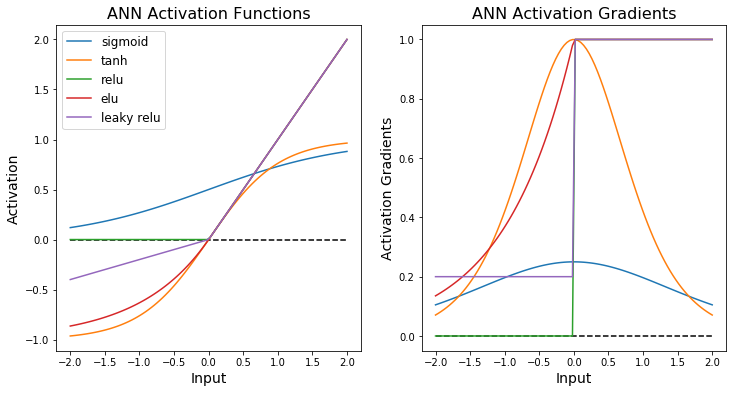

In [4]:
# Placeholder input tensor allows for numpy arrays to be fed through the function into Tensorflow
act_in = K.placeholder()
# List of activations
activations = ["sigmoid", "tanh", "relu", "elu"]
act_funcs = []
in_vals = np.linspace(-2, 2, 100)
out_vals = []
plt.figure(figsize=(12, 6))
# Plot each activation function
plt.subplot(1, 2, 1)
plt.plot(in_vals, np.zeros(in_vals.shape), 'k--')
for act in activations:
    # K.function creates a general input-output function between 2 connected keras tensors
    act_funcs.append(K.function([act_in], [Activation(act)(act_in)]))
    out_vals.append(act_funcs[-1]([in_vals])[0])
    plt.plot(in_vals, out_vals[-1], label=act)
act_funcs.append(K.function([act_in], [LeakyReLU(0.2)(act_in)]))
out_vals.append(act_funcs[-1]([in_vals])[0])
plt.plot(in_vals, out_vals[-1], label="leaky relu")
plt.xlabel("Input", fontsize=14)
plt.ylabel("Activation", fontsize=14)
plt.title("ANN Activation Functions", fontsize=16)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
# Plot the gradients of each activation function
plt.plot(in_vals, np.zeros(in_vals.shape), 'k--')
for act in activations:
    # K.gradients calculates the gradient between an arbitrary input and output pairing
    act_funcs.append(K.function([act_in], K.gradients(Activation(act)(act_in), act_in)))
    out_vals.append(act_funcs[-1]([in_vals])[0])
    plt.plot(in_vals, out_vals[-1], label=act)
act_funcs.append(K.function([act_in], K.gradients(LeakyReLU(0.2)(act_in), act_in)))
out_vals.append(act_funcs[-1]([in_vals])[0])
plt.plot(in_vals, out_vals[-1], label="leaky relu")
plt.xlabel("Input", fontsize=14)
plt.ylabel("Activation Gradients", fontsize=14)
plt.title("ANN Activation Gradients", fontsize=16)

Common activation functions are plotted above. Classical ANNs used a sigmoid or hyperbolic tangent (tanh) activation function to mimic the activation of neurons in the brain. The problem with sigmoids, and to a lesser extent with tanh, is that when error information is backpropagated through the network, the maximum gradient (derivative of input with respect to change in output) of the sigmoid is around 0.3, so each backward pass through a sigmoid reduces the magnitude of the gradient by 70% or more. This leads to the "vanishing gradient problem" for deep neural networks. After 2 or 3 layers the magnitude of the gradient is too small to provide a consistent signal about how the weights should be updated, resulting in poor convergence of the model.

The Rectifed Linear Unit (ReLU) activation solves this issue by performing a transform such that positive values retain their original magnitude while negative values are set to 0. Because the magnitude of the positive gradient does not decrease, the gradient signal can be propagated through many layers without vanishing. Zeroing out the negative gradient can sometimes lead to dead neurons, so variants of the ReLU, such as the Leaky ReLU and the Exponential Linear Unit (ELU) have been created to propagate negative information but at a reduced magnitude.

An Optimizer controls how the model weights are updated. Two popular optimizers in Keras are SGD and Adam. Neural networks are generally optimized through the process of gradient descent, in which the values of network weights $\theta$ are updated based on the gradient of the loss function:

$\hat{g}=\frac{1}{m}\nabla_{\theta}\sum L(f(x;\theta), y)$

$\theta=\theta-\epsilon \hat{g}$.

The size of the update is controlled by the learning rate $\epsilon$. A larger learning rate results in faster convergence, but too large a learning rate can cause the optimizer to overshoot the global minimum. If the learning rate is too small, the optimizer can get trapped in a local minimum or just never converge. Specialized optimizer functions have been developed to address some of these issues.

SGD: Stochastic Gradient Descent. The stochastic component comes from selecting a random "batch" of training examples for each update. SGD includes an option to add momentum to the gradient descent update, which allows the optimizer to retain a memory of what the previous gradients were to reduce the variance in stochastic gradient computations. A high momentum value around 0.99 is generally recommended in practice.

Adam: Short for "adaptive moments." This optimizer automatically updates the learning rate based on the first and second moments of the gradient. The key parameters are `beta_1` and `beta_2`, which default to 0.9 and 0.99 respectively. I have had some success setting the learning rate and beta_1 to lower values, but the default values work well.

In [196]:
batch_size = 128
num_epochs = 10
hidden_neurons = 10
learning_rate = 1
optimizer = SGD(lr=learning_rate)
loss = "binary_crossentropy"
small_net_input = Input(shape=(len(input_columns),))
small_net_hidden = Dense(hidden_neurons, activation="relu")(small_net_input)
small_net_out = Dense(1, activation="sigmoid")(small_net_hidden)
small_model = Model(small_net_input, small_net_out)
small_model.compile(optimizer, loss=loss)
#small_model.compile(Adam(lr=0.001), loss="binary_crossentropy")

batch_diff = train_norm.shape[0] % batch_size
batch_indices = np.random.permutation(np.arange(train_norm.shape[0] - batch_diff))
num_batches = int(batch_indices.size / batch_size)
hw, hb, ow, ob = small_model.get_weights()
hw_series = np.zeros([num_batches * num_epochs] + list(hw.shape))
ow_series = np.zeros([num_batches * num_epochs] + list(ow.shape))
hw_series[0] = hw
ow_series[0] = ow
i = 0
for e in range(num_epochs):
    batch_indices = np.random.permutation(batch_indices)
    for b in range(num_batches):
        hw_series[i], hb, ow_series[i], ob = small_model.get_weights()
        small_model.train_on_batch(train_norm[batch_indices[b * batch_size: (b + 1) * batch_size]],
                                   train_out[batch_indices[b * batch_size: (b + 1) * batch_size]])
        
        i += 1

Text(0.5,1,'Output Layer Weights Optimized')

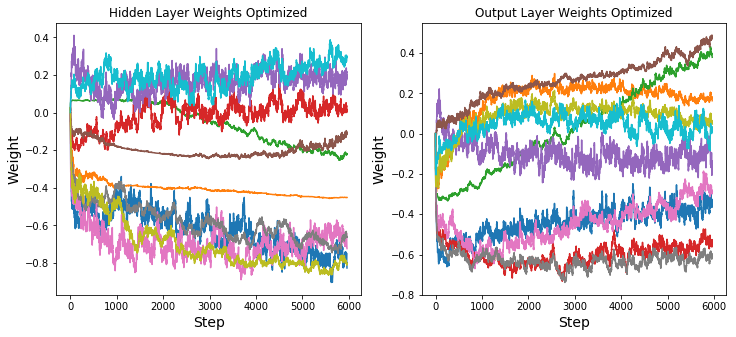

In [197]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
hw_flat = hw_series.reshape(hw_series.shape[0], hw_series.shape[1] * hw_series.shape[2])
for i in range(10):
    plt.plot(hw_flat[:, i] - hw_flat[0, i])
plt.xlabel("Step", fontsize=14)
plt.ylabel("Weight", fontsize=14)
plt.title("Hidden Layer Weights Optimized")
plt.subplot(1, 2, 2)
ow_flat = ow_series.reshape(ow_series.shape[0], ow_series.shape[1] * ow_series.shape[2])
for i in range(10):
    plt.plot(ow_flat[:, i] - ow_flat[0, i])
plt.xlabel("Step", fontsize=14)
plt.ylabel("Weight", fontsize=14)
plt.title("Output Layer Weights Optimized")

In [119]:
small_model.fit(train_norm, train_out, epochs=10, batch_size=256)

Epoch 1/10
76377/76377 [==============================] - 1s 7us/step - loss: 0.2061
Epoch 2/10
76377/76377 [==============================] - 0s 4us/step - loss: 0.1385
Epoch 3/10
76377/76377 [==============================] - 0s 3us/step - loss: 0.1508
Epoch 4/10
76377/76377 [==============================] - 0s 4us/step - loss: 0.1519
Epoch 5/10
76377/76377 [==============================] - 0s 4us/step - loss: 0.1530
Epoch 6/10
76377/76377 [==============================] - 0s 3us/step - loss: 0.1507
Epoch 7/10
76377/76377 [==============================] - 0s 3us/step - loss: 0.1479
Epoch 8/10
76377/76377 [==============================] - 0s 4us/step - loss: 0.1431
Epoch 9/10
76377/76377 [==============================] - 0s 3us/step - loss: 0.1533
Epoch 10/10
76377/76377 [==============================] - 0s 3us/step - loss: 0.1666


In [55]:
target = K.placeholder(shape=(1,1))
loss = K.mean((small_model.output - target) ** 2)
grads = K.gradients(loss, small_model.layers[1].weights + small_model.layers[2].weights)
grad_func = K.function([small_model.input, target], grads)

In [70]:
hidden_weight_grad, hidden_bias_grad, \
    out_weight_grad, out_bias_grad = grad_func([test_norm[256:258], np.array([[1]])])

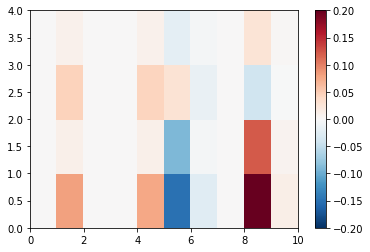

In [71]:
plt.pcolormesh(hidden_weight_grad, vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.colorbar()

## Convolutional Neural Network

In [195]:
# Input data in shape (y, x, variable)
conv_net_in = Input(shape=all_in_data.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(8, (5, 5), padding="same")(conv_net_in)
conv_net = Activation("relu")(conv_net)
conv_net = Dropout(0.1)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(16, (5, 5), padding="same")(conv_net)
conv_net = Activation("relu")(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Third set of convolution and pooling layers
conv_net = Conv2D(32, (5, 5), padding="same")(conv_net)
conv_net = Activation("relu")(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Dense output layer, equivalent to a logistic regression on the last layer
conv_net = Dense(1)(conv_net)
conv_net = Activation("sigmoid")(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam()
conv_model.compile(opt, "mse", metrics=[brier_skill_score_keras])

NameError: name 'brier_skill_score_keras' is not defined